In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 1 columns):
KPI    4032 non-null int64
dtypes: int64(1)
memory usage: 31.6 KB


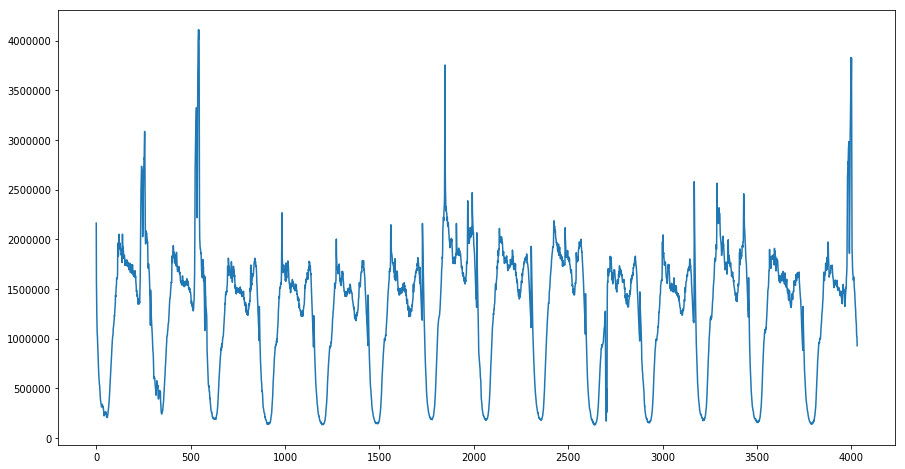

In [2]:
source_data = pd.read_csv('KPI_new.csv', usecols=[1])
source_data.info()
source_data.describe()
plt.figure(figsize=(15, 8))
plt.plot(source_data)

In [3]:
source_series = source_data.values

[2163288.         2163288.         1501860.67590028 1063557.26267447
  938775.29730127  910599.98623074  920048.94707552  955619.64092744
  934419.92841326  845117.84218485]


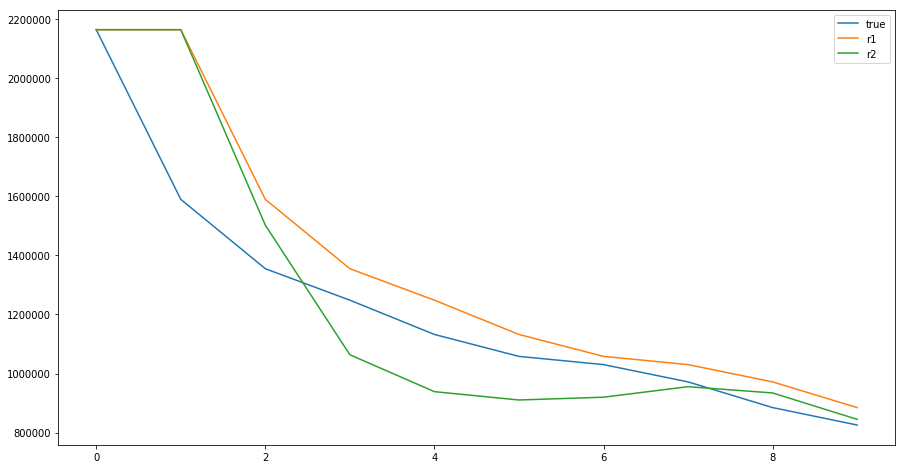

In [4]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
ets1 = SimpleExpSmoothing(source_series[:10])
ets2 = Holt(source_series[:10])
#ets3 = ExponentialSmoothing(source_series[:10], trend='add', seasonal='add', seasonal_periods=25)
r1 = ets1.fit()
r2 = ets2.fit()
#r3 = ets3.fit()
plt.figure(figsize=(15,8))
plt.plot(source_series[:10], label='true')
plt.plot(r1.fittedvalues, label='r1')
plt.plot(r2.fittedvalues, label='r2')
plt.legend(loc='best')
print(r2.fittedvalues)

### 对全局进行3$\sigma$法则,超出界限的点转换为前100个点的最值；局部进行双指数平滑，采用左5和右5个点，从而考虑了趋势。

In [5]:
from statsmodels.tsa.holtwinters import Holt
def source2normal(ts):
    abnormal_global_points = []
    abnormal_local_points = []
    
    miu = np.mean(ts)
    sigma = np.std(ts)
    L = 3
    UCL = miu + L * sigma
    LCL = miu - L * sigma
    print("miu = %f" % miu)
    print("sigma = %f" % sigma)
    print("Upper Control Line = %f" % UCL)
    print("Lower Control Line = %f" % LCL)
    for i in range(len(ts)):
        if ts[i] > UCL:
            abnormal_global_points.append(i)
            # 列表切片是左闭右开区间，且倒序的右开区间最小等于0，故取前100个点需从第102个点开始
            if i > 100:
                ts[i] = np.max(ts[i-1:i-101:-1])
            else:
                ts[i] = np.max(ts[i-1::-1])
        if ts[i] < LCL:
            abnormal_global_points.append(i)
            if i > 100:
                ts[i] = np.min(ts[i-1:i-101:-1])
            else:
                ts[i] = np.min(ts[i-1::-1])
        # 局部双指数平滑，计算某个点的左五后右五个点的CL，异常则把该点平滑
        if i > 4 or i < len(ts)-6:
            miu_local = np.mean(ts[i-5:i+6])
            sigma_local = np.std(ts[i-5:i+6])
            # 经观察，局部有趋势，方差不应该很大，应该收拢CL
            L_local = 2.2
            UCL_local = miu_local + L_local * sigma_local
            LCL_local = miu_local - L_local * sigma_local
            if ts[i] > UCL_local or ts[i] < LCL_local:
                abnormal_local_points.append(i)
                DESmodel = Holt(ts[i-5:i+6]).fit()
                ts[i] = DESmodel.fittedvalues[5]
    return ts, abnormal_global_points, abnormal_local_points

miu = 1289001.773065
sigma = 628198.297943
Upper Control Line = 3173596.666894
Lower Control Line = -595593.120763


/home/pyn/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pyn/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pyn/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pyn/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pyn/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[528, 529, 530, 531, 532, 537, 538, 539, 540, 541, 542, 543, 544, 545, 1847, 1848, 3996, 3997, 3998, 3999, 4000, 4001]
[120, 162, 457, 480, 716, 752, 763, 984, 1005, 1583, 1657, 1664, 1901, 1908, 1909, 1968, 1992, 1993, 3060, 3341, 3348]


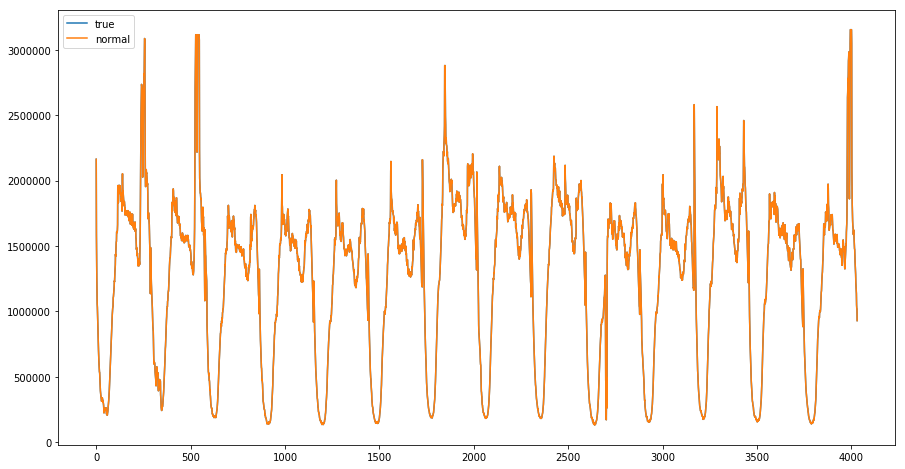

In [6]:
normal_series, global_points, local_points = source2normal(source_series)
print(global_points)
print(local_points)
plt.figure(figsize=(15,8))
plt.plot(source_series, label='true')
plt.plot(normal_series, label='normal')
plt.legend(loc='best')

In [7]:
print(normal_series[2500:2800])

[[1799643]
 [1793175]
 [1800999]
 [1790936]
 [1821894]
 [1775811]
 [1778680]
 [1806778]
 [1747423]
 [1746972]
 [1734722]
 [1729856]
 [1696343]
 [1696269]
 [1664471]
 [1662093]
 [1677804]
 [1695379]
 [1659357]
 [1622125]
 [1588943]
 [1557718]
 [1528931]
 [1543106]
 [1532307]
 [1529966]
 [1460613]
 [1463285]
 [1460057]
 [1502796]
 [1470406]
 [1440996]
 [1455007]
 [1442504]
 [1448231]
 [1472111]
 [1521685]
 [1530745]
 [1563148]
 [1552583]
 [1556541]
 [1576047]
 [1598202]
 [1865778]
 [1832379]
 [1782538]
 [1770130]
 [1792636]
 [1791316]
 [1795783]
 [1810359]
 [1820079]
 [1781898]
 [1829484]
 [1875357]
 [1890656]
 [1916077]
 [1910235]
 [1953531]
 [1974596]
 [1967856]
 [1946010]
 [1949528]
 [1929204]
 [1931783]
 [1970068]
 [1940096]
 [1951747]
 [2000655]
 [1951210]
 [1921395]
 [1910148]
 [1870157]
 [1872566]
 [1838461]
 [1791735]
 [1766024]
 [1744002]
 [1706953]
 [1655532]
 [1600513]
 [1576622]
 [1533882]
 [1467337]
 [1398065]
 [1369155]
 [1311444]
 [1270870]
 [1234505]
 [1189995]
 [1151066]

##### 结果表明局部双指平滑对2700左右位置的点并没有作用，仍需改进

### 数据归一化

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_series = scaler.fit_transform(normal_series)
print(scaler_series)
# origindata = scaler.inverse_transform(scaler_series)
# print(origindata)

[[0.67230476]
 [0.48244584]
 [0.40483768]
 ...
 [0.29467148]
 [0.29408105]
 [0.2641216 ]]


/home/pyn/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

### 构造数据集

In [10]:
# 通过之前的look_back个点来预测后一个点
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i: i + look_back]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [11]:
from sklearn.model_selection import train_test_split
x, y = create_dataset(scaler_series)
x = x.astype(np.float32) # 很关键，默认为float64
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [12]:
print(len(X_train))
print(y_train)
print(len(X_test))
print(y_test)

2815
[[0.615301  ]
 [0.4865167 ]
 [0.48990387]
 ...
 [0.37977934]
 [0.04310583]
 [0.5158024 ]]
1207
[[0.00137835]
 [0.29070416]
 [0.26452383]
 ...
 [0.5497017 ]
 [0.4396923 ]
 [0.04336913]]


### 搭建模型

In [13]:
import torch
from torch import nn
from torch.autograd import Variable

look_back = 10
X_train = X_train.reshape(-1, 1, look_back)
y_train = y_train.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, look_back)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)

# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [14]:
net = lstm_reg(look_back, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)

In [15]:
from tqdm import tqdm
train_loss = []
iteration = 1000
for i in tqdm(range(iteration)):
    var_x = Variable(X_train)
    var_y = Variable(y_train)
    
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if (i + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(i + 1, loss.item()))

 10%|█         | 100/1000 [01:58<17:14,  1.15s/it]

Epoch: 100, Loss: 0.04007


 20%|██        | 200/1000 [03:53<14:35,  1.09s/it]

Epoch: 200, Loss: 0.02750


 30%|███       | 300/1000 [05:47<12:49,  1.10s/it]

Epoch: 300, Loss: 0.00742


 40%|████      | 400/1000 [07:41<10:47,  1.08s/it]

Epoch: 400, Loss: 0.00384


 50%|█████     | 500/1000 [09:36<09:42,  1.16s/it]

Epoch: 500, Loss: 0.00253


 60%|██████    | 600/1000 [11:30<07:48,  1.17s/it]

Epoch: 600, Loss: 0.00201


 70%|███████   | 700/1000 [13:26<05:39,  1.13s/it]

Epoch: 700, Loss: 0.00163


 80%|████████  | 800/1000 [15:19<03:54,  1.17s/it]

Epoch: 800, Loss: 0.00138


 90%|█████████ | 900/1000 [17:13<01:56,  1.16s/it]

Epoch: 900, Loss: 0.00122


100%|██████████| 1000/1000 [19:07<00:00,  1.09s/it]

Epoch: 1000, Loss: 0.00111


### 预测时间序列

In [29]:
net_pre = net.eval()
xx = x.reshape(-1, 1, look_back)
xx = torch.from_numpy(xx)
var_data = Variable(xx)
# 预测结果
pred_test = net(var_data)

In [35]:
print(len(pred_test))
pred_test
#pred_test = pred_test.view(-1).data.numpy()

4022


array([[[-0.02297148]],

       [[ 0.09597293]],

       [[ 0.13048238]],

       ...,

       [[ 0.27726126]],

       [[ 0.26176125]],

       [[ 0.26193443]]], dtype=float32)

In [50]:
pred_test = pred_test.reshape(1, -1)
# 还原
result_data = scaler.inverse_transform(pred_test).flatten()

In [51]:
result_data

array([ 61337.914, 420929.1  , 525257.6  , ..., 968997.6  , 922138.2  ,
       922661.75 ], dtype=float32)

In [52]:
len(result_data)

4022

In [53]:
# MAPE误差
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 预测是从第11个点开始的，所以这边的误差比较会忽略前10个点

error = mean_squared_error(source_series[look_back:], result_data)
print('Test MSE: %.3f' % error)
error = mean_absolute_error(source_series[look_back:], result_data)
print('Test MAE: %.3f' % error)
error = mean_absolute_percentage_error(source_series[look_back:], result_data)
print('Test MAPE: %.3f' % error)

Test MSE: 10604497877.221
Test MAE: 59028.346
Test MAPE: 121.467


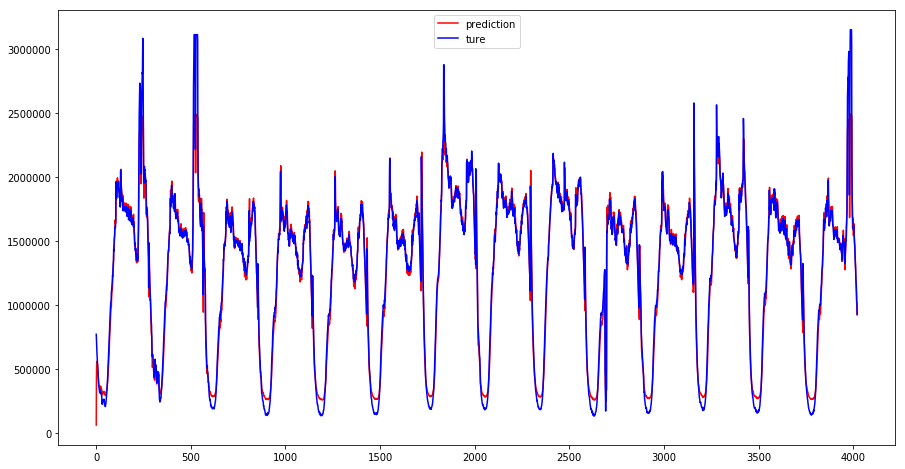

In [55]:
plt.figure(figsize=(15,8))
plt.plot(result_data, 'r', label='prediction')
plt.plot(source_series[look_back:], 'b', label='ture')
plt.legend(loc='best')

In [112]:
newIndex = range(look_back, len(result_data) + look_back)
result = pd.Series(result_data, index=newIndex)
result.to_csv('LSTM_smoothing_prediction_MAE_59028_MAPE_121.CSV')

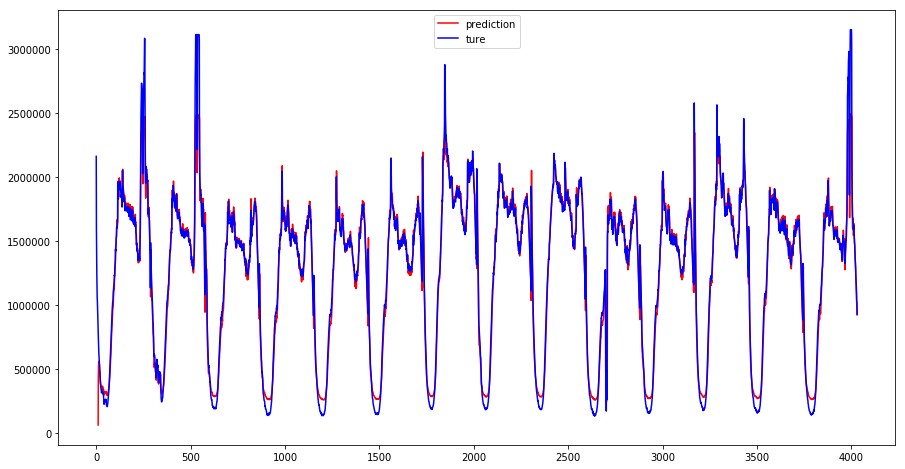

In [57]:
plt.figure(figsize=(15,8))
plt.plot(result, 'r', label='prediction')
plt.plot(source_series, 'b', label='ture')
plt.legend(loc='best')

In [58]:
result.describe()

count    4.022000e+03
mean     1.285365e+06
std      5.909352e+05
min      6.133791e+04
25%      7.814006e+05
50%      1.486023e+06
75%      1.729277e+06
max      2.495493e+06
dtype: float64

In [82]:
# 找到指标最大的几个异常点，或指定一个指标，大于该指标的为异常点
def findAbnormalPoints(source, result, quota, MAE=False, MAPE=False):
    if MAE is True and MAPE is True:
        print("Parameter MAE and MAPE can not be True at the same time")
        return None
    if len(source) != len(result):
        print("The length of source and result must be the same")
        return None
    
    ab_index = []
    
    if MAE is True:
        for i in range(len(source)):
            if abs(source[i] - result[i]) > quota:
                ab_index.append(i)
    elif MAPE is True:
        for i in range(len(source)):
            if abs((source[i] - result[i]) / source[i]) > quota:
                ab_index.append(i)
    else:
        MAE_set = {}
        MAPE_set = {}
        MAE_min_key, MAPE_min_key = '-1', '-1'
        MAE_min_value, MAPE_min_value = -1, -1
        
        for i in range(len(source)):
            MAE_value = abs(source[i] - result[i])
            MAPE_value = abs((source[i] - result[i]) / source[i])
          
            if len(MAE_set) >= quota:
                if MAE_value > MAE_min_value: 
                    MAE_set.pop(MAE_min_key)
                    MAE_set[str(i)] = MAE_value
                    MAE_min_key = min(MAE_set, key=MAE_set.get)
                    MAE_min_value = MAE_set[MAE_min_key]    
            else:
                MAE_set[str(i)] = MAE_value
                # 看着很冗余，实际上可以减少运算次数
                MAE_min_key = min(MAE_set, key=MAE_set.get)
                MAE_min_value = MAE_set[MAE_min_key]         
            
            if len(MAPE_set) >= quota:
                if MAPE_value > MAPE_min_value: 
                    MAPE_set.pop(MAPE_min_key)
                    MAPE_set[str(i)] = MAPE_value
                    MAPE_min_key = min(MAPE_set, key=MAPE_set.get)
                    MAPE_min_value = MAPE_set[MAPE_min_key]    
            else:
                MAPE_set[str(i)] = MAPE_value
                MAPE_min_key = min(MAPE_set, key=MAPE_set.get)
                MAPE_min_value = MAPE_set[MAPE_min_key]
        
        ab_index1 = []
        ab_index2 = []
        for key1, key2 in zip(MAE_set, MAPE_set):
            ab_index1.append(int(key1))
            ab_index2.append(int(key2))
        ab_index.append(ab_index1)
        ab_index.append(ab_index2)
    
    return ab_index   

In [102]:
def show(ab_index):
    print(len(ab_index))
    if len(ab_index) == 2:
        for i in ab_index[0]:
            real_key = int(i) + look_back
            print('index = %d, true = %f, predicted = %f' % (real_key, source_series[real_key], result_data[real_key]))
        print('\n')
        for i in ab_index[1]:
            real_key = int(i) + look_back
            print('index = %d, true = %f, predicted = %f' % (real_key, source_series[real_key], result_data[real_key]))
    if len(ab_index) > 2:
        for i in ab_index:
            real_key = int(i) + look_back
            print('index = %d, true = %f, predicted = %f' % (real_key, source_series[real_key], result_data[real_key]))

In [106]:
# 分别选取AE和APE最大的10个点
ab_index = findAbnormalPoints(source_series[10:], result_data, 10)
show(ab_index)

2
index = 10, true = 771212.000000, predicted = 448599.906250
index = 536, true = 2889906.000000, predicted = 2469781.250000
index = 537, true = 3115286.000000, predicted = 2461180.250000
index = 576, true = 1623847.000000, predicted = 1176303.500000
index = 1728, true = 2160158.000000, predicted = 1111447.125000
index = 2016, true = 2066011.000000, predicted = 922895.562500
index = 2304, true = 1929575.000000, predicted = 931980.937500
index = 2707, true = 1365832.000000, predicted = 1706826.250000
index = 3168, true = 2580894.000000, predicted = 988968.937500
index = 3998, true = 3153972.000000, predicted = 1680484.375000


index = 10, true = 771212.000000, predicted = 448599.906250
index = 913, true = 136369.000000, predicted = 266999.375000
index = 1195, true = 134952.000000, predicted = 259277.500000
index = 1201, true = 135100.000000, predicted = 267729.468750
index = 1202, true = 134767.000000, predicted = 270139.937500
index = 1203, true = 134707.000000, predicted = 270305.5937

8
index = 10, true = 771212.000000, predicted = 448599.906250
index = 536, true = 2889906.000000, predicted = 2469781.250000
index = 537, true = 3115286.000000, predicted = 2461180.250000
index = 1728, true = 2160158.000000, predicted = 1111447.125000
index = 2016, true = 2066011.000000, predicted = 922895.562500
index = 2304, true = 1929575.000000, predicted = 931980.937500
index = 2707, true = 1365832.000000, predicted = 1706826.250000
index = 3168, true = 2580894.000000, predicted = 988968.937500


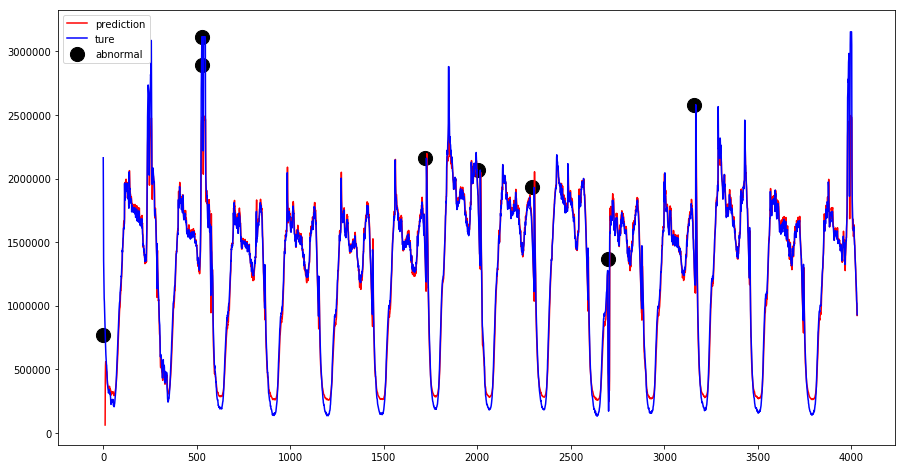

In [107]:
# 选取AE大于阈值的点
ab_index = findAbnormalPoints(source_series[10:], result_data, 700000, MAE=True)
show(ab_index)

ab_value = []
for i in ab_index:
    real_index = int(i) + look_back
    ab_value.append(source_series[real_index])

plt.figure(figsize=(15,8))
plt.plot(result, 'r', label='prediction')
plt.plot(source_series, 'b', label='ture')
plt.scatter(ab_index, ab_value, s=200, marker='o', color='black', label='abnormal')
plt.legend(loc='best')

##### 对2700位置的点模型也能完美拟合，所以还是有问题的

12
index = 10, true = 771212.000000, predicted = 448599.906250
index = 905, true = 139318.000000, predicted = 262451.375000
index = 913, true = 136369.000000, predicted = 266999.375000
index = 1195, true = 134952.000000, predicted = 259277.500000
index = 1201, true = 135100.000000, predicted = 267729.468750
index = 1202, true = 134767.000000, predicted = 270139.937500
index = 1203, true = 134707.000000, predicted = 270305.593750
index = 2634, true = 142951.000000, predicted = 261098.203125
index = 2635, true = 138630.000000, predicted = 261105.093750
index = 2640, true = 130785.000000, predicted = 266161.562500
index = 2641, true = 130984.000000, predicted = 268543.500000
index = 3788, true = 139884.000000, predicted = 267696.625000


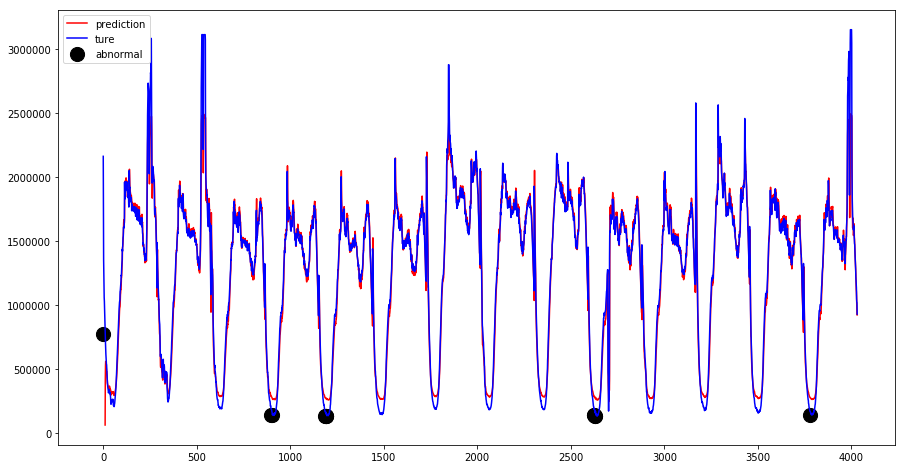

In [108]:
# 选取APE大于阈值的点
ab_index = findAbnormalPoints(source_series[10:], result_data, 0.9, MAPE=True)
show(ab_index)

ab_value = []
for i in ab_index:
    real_index = int(i) + look_back
    ab_value.append(source_series[real_index])

plt.figure(figsize=(15,8))
plt.plot(result, 'r', label='prediction')
plt.plot(source_series, 'b', label='ture')
plt.scatter(ab_index, ab_value, s=200, marker='o', color='black', label='abnormal')
plt.legend(loc='best')

##### 使用MAPE指标的最大缺点就是原值在靠近0的时候容易放大误差值，导致误判